In [8]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print
    
def init_distributed():

    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    dist_url = "env://" # default
    # only works with torch.distributed.launch // torch.run
    rank = int(os.environ["RANK"])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])

    dist.init_process_group(
            backend="nccl",
            init_method=dist_url,
            world_size=world_size,
            rank=rank)

    # this will make all .cuda() calls work properly
    try:
        torch.cuda.set_device(local_rank)
    except:
        print("error at", local_rank)
    # synchronizes all the threads to reach this point before moving on
    dist.barrier()
    setup_for_distributed(rank == 0)

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import copy
import time
import math
import command
import random
import sys
import h5py

#os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

import cv2
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 8

from skimage import img_as_ubyte
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import *
from sklearn.metrics import *

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch_3d as smp
import timm
from torchtoolbox.tools import mixup_data, mixup_criterion
import torchvision as tv
from torch_ema import ExponentialMovingAverage

from transformers import get_cosine_schedule_with_warmup

import torch.distributed as dist

import logging
logging.getLogger('timm').setLevel(logging.WARNING)

#import redis
#import pickle
#redis_cache = redis.StrictRedis(host='localhost', port=6379, db=0)
#redis_cache.flushdb()

In [9]:
class CFG:
    DDP = 1
    DDP_INIT_DONE = 0
    N_GPUS = 2
    FOLD = 0
    FULLDATA = 0
    
    model_name = -1
    V = -1
    
    OUTPUT_FOLDER = f"./data/segmentation_model/{model_name}_v{V}"
    
    seed = 3407
    
    device = torch.device('cuda')
    
    n_folds = 4
    
    image_size = [256, 256]
    
    train_batch_size = 32
    valid_batch_size = 32
    acc_steps = 1
    
    lr = 1e-3
    wd = 1e-5
    ema_decay_per_epoch = 0.3
    freeze_epochs = 0
    n_epochs = 12
    n_warmup_steps = 0
    upscale_steps = 1.5
    validate_every = 2
    
    epoch = 0
    global_step = 0
    literal_step = 0
    
    autocast = True
    
    workers = 8

if CFG.FULLDATA:
    CFG.seed = CFG.FOLD
    
OUTPUT_FOLDER = CFG.OUTPUT_FOLDER
        
CFG.cache_dir = CFG.OUTPUT_FOLDER + f'/cache/'
os.makedirs(CFG.cache_dir, exist_ok=1)

seed_everything(CFG.seed)

In [10]:
segmentation_folders = np.array([x.split('/')[-1].replace('.nii', '') for x in glob('./data/train_images_npy/*')])
segmentation_folders.shape, segmentation_folders[:5]

((2019,),
 array(['1.2.826.0.1.3680043.3306', '1.2.826.0.1.3680043.27325',
        '1.2.826.0.1.3680043.5476', '1.2.826.0.1.3680043.20061',
        '1.2.826.0.1.3680043.23968'], dtype='<U25'))

In [11]:
DAT = {'folder_name': [], 'image_path': [],}

for folder in segmentation_folders:
    
    image_files = sorted(glob(f'./data/train_images_npy/{folder}/*.npy'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
    
    DAT['folder_name'].extend([folder]*len(image_files))
    DAT['image_path'].extend(image_files)
    
data = pd.DataFrame(DAT)
data

,folder_name,image_path
0,1.2.826.0.1.3680043.3306,./data/train_images_npy/1.2.826.0.1.3680043.33...
1,1.2.826.0.1.3680043.3306,./data/train_images_npy/1.2.826.0.1.3680043.33...
2,1.2.826.0.1.3680043.3306,./data/train_images_npy/1.2.826.0.1.3680043.33...
3,1.2.826.0.1.3680043.3306,./data/train_images_npy/1.2.826.0.1.3680043.33...
4,1.2.826.0.1.3680043.3306,./data/train_images_npy/1.2.826.0.1.3680043.33...
...,...,...
711596,1.2.826.0.1.3680043.23957,./data/train_images_npy/1.2.826.0.1.3680043.23...
711597,1.2.826.0.1.3680043.23957,./data/train_images_npy/1.2.826.0.1.3680043.23...
711598,1.2.826.0.1.3680043.23957,./data/train_images_npy/1.2.826.0.1.3680043.23...
711599,1.2.826.0.1.3680043.23957,./data/train_images_npy/1.2.826.0.1.3680043.23...


In [3]:
(58.3 / 29832) * 711601

1390.6656710914453

In [12]:
class SpineDataset(Dataset):
    def __init__(self, data, transforms=None, is_training=False):
        self.data = data
        self.transforms = transforms
        self.is_training = is_training
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        row = self.data.iloc[i]
        folder = row.folder_name
        image_path = row.image_path
        
        image = np.load(image_path)
        
        try:
            row_prev = self.data.iloc[i-2]
            row_next = self.data.iloc[i+2]
        except:
            row_prev = row
            row_next = row
        
        if row_prev.folder_name!=row.folder_name:
            row_prev = row
        if row_next.folder_name!=row.folder_name:
            row_next = row
        
        try: image_prev = np.load(row_prev.image_path)
        except: image_prev = image
        try: image_next = np.load(row_next.image_path)
        except: image_next = image
        
        image = np.stack([image_prev, image, image_next], -1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
            
            if image.dtype==torch.uint8: image = image.float() / image.max()
            
        return {
            'images': image,
            'ids': f"{image_path}"
        }

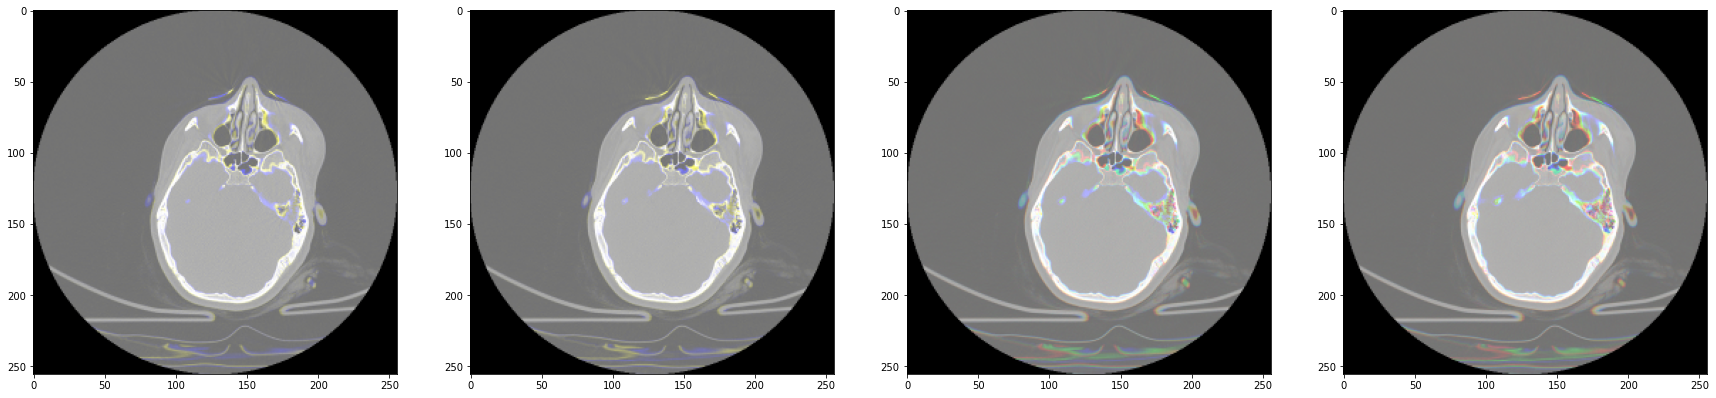

In [14]:
def get_loaders(ret_data=False, n_workers=CFG.workers):
    train_data = data.copy()#.iloc[folds[CFG.FOLD][0]]
    valid_data = data.copy()#.iloc[folds[CFG.FOLD][1]]
    
    train_transforms = A.Compose([
        A.Resize(*CFG.image_size),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])

    valid_transforms = A.Compose([
        A.Resize(*CFG.image_size),
        ToTensorV2()
    ])
    
    train_dataset = SpineDataset(train_data, train_transforms, 1)
    valid_dataset = SpineDataset(valid_data, valid_transforms, 0)
    
    if CFG.DDP and CFG.DDP_INIT_DONE:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list)//CFG.N_GPUS)
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset=train_dataset, shuffle=True, drop_last=True)
        train_sampler.set_epoch(CFG.epoch) #needed for shuffling?
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False, drop_last=True)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(dataset=valid_dataset, shuffle=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, sampler=valid_sampler, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    else:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list))
        #train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False)
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True, num_workers=n_workers, pin_memory=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=n_workers, pin_memory=False)
    
    #RUINS VALID-LOADER DDP
    #valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    
    CFG.steps_per_epoch = math.ceil(len(train_loader) / CFG.acc_steps)
    
    if ret_data:
        return train_loader, valid_loader, train_data, valid_data
    return train_loader, valid_loader
    
#train_loader, valid_loader = get_loaders(ret_data=False, n_workers=0)
train_loader, valid_loader, train_data, valid_data = get_loaders(ret_data=True, n_workers=4)

#seed_everything(42)

for d in valid_loader: break
    
#_, axs = plt.subplots(2, 4, figsize=(24, 12))
_, axs = plt.subplots(1, 4, figsize=(30, 15))
axs = axs.flatten()
for img, ax in zip(range(4), axs):
    try:
        ax.imshow(d['images'][img].numpy().transpose(1,2,0), cmap='gray')
    except: pass

In [15]:
CFG.n_classes = 8

class SMPModel(nn.Module):
    def __init__(self, pretrained=True, drop=0.):
        super(Model, self).__init__()
        
        self.segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=d['images'].shape[1], classes=CFG.n_classes, aux_params={'classes': CFG.n_classes})
        #self.segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=d['images'].shape[1], classes=CFG.n_classes)
        
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)
        
        masks, logits = self.segmentor(inp)
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        masks = torch.nan_to_num(masks, 0, 0, 0)
        
        return logits, masks
    
Model = SMPModel

In [16]:
if CFG.model_name==-1: CFG.model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'

#CFG.model_name = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
#CFG.model_name = 'coat_lite_medium_384.in1k'
#CFG.model_name = 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k'

#'''
model = Model()

model.eval()

#t = time.time()
with torch.no_grad():
    outs = model(d['images'][:2])
#print(time.time() - t)
_ = [print(o.shape) for o in outs if o!=None]

torch.Size([2, 8])
torch.Size([2, 8, 256, 256])


In [18]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    changes = np.where(pixels[1:] != pixels[:-1])[0]
    starts = changes[::2]
    lengths = changes[1::2] - starts
    return list(zip(starts, lengths))

def rle_decode(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in rle:
        mask[start:start + length] = 1
    return mask.reshape(shape)

def predict(models, loader):
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    DAT = {col: [] for col in ['image_path'] + [f'rle_c{i}' for i in range(1, 9)]}
    
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            ids = data['ids']
            
            masks = []
            for model in models:
                with torch.cuda.amp.autocast(enabled=CFG.autocast):
                    logits, logits_mask = model(images)
                    
                    outputs = logits_mask.float().sigmoid().detach().cpu().numpy()
                    masks.append(outputs)
            
            masks = np.stack(masks).mean(0)
            
            threshold = 0.5
            for mask, iid in zip(masks, ids):
                DAT['image_path'].append(iid)
                
                for cl in range(8):
                    rle = rle_encode((mask[cl]>threshold).astype(np.uint8))
                    DAT[f'rle_c{cl+1}'].append(rle)
            
    return DAT

In [19]:
model_paths = [f'./data/segmentation_model/tf_efficientnetv2_s.in21k_ft_in1k_v5/{F}_best.pth' for F in range(4)]
models = []
for model_path in tqdm(model_paths):
    model = Model()
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()
    model.cuda()
    models.append(copy.deepcopy(model))
len(models)

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


4

In [20]:
DAT = predict(models, valid_loader)

15424/22238 1:40:48<43:13   

In [21]:
predictions = pd.DataFrame(DAT)
predictions

In [22]:
predictions.to_csv('./data/train_segmentations.csv', index=False)

In [1]:
import pandas as pd

In [2]:
train_segmentations = pd.read_csv('./data/train_segmentations.csv')
train_segmentations

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8
0,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[]
1,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[]
2,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[]
3,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[]
4,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...
711596,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(42870, 4), (43125, 8), (43379, 12), (43633, ..."
711597,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(42871, 2), (43124, 9), (43379, 11), (43633, ..."
711598,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(43125, 7), (43379, 11), (43633, 15), (43888,..."
711599,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(43891, 3), (44146, 3), (44400, 4), (44654, 6..."


In [6]:
mask_data = {}
for i, row in tqdm(train_segmentations.iterrows(), total=len(train_segmentations)):
    folder = row.image_path.split('/')[-2]
    if folder not in mask_data:
        mask_data[folder] = {f"C{c}": [] for c in range(1,9)}
    
    for C in range(1,9):
        mask_data[folder][f'C{C}'].append(eval(row[f'rle_c{C}']))
    
    #break

100%|██████████| 711601/711601 [04:33<00:00, 2602.98it/s]


In [7]:
np.save('./data/train_mask_data.npy', mask_data)